In [86]:
import os
import re
import shutil
import glob
import numpy as np
import cv2
import skimage.util
import skimage.io
import pylab as pl
import scipy.spatial.distance as spdist
from sklearn.cross_validation import train_test_split
import matplotlib.cm as cm

from collections import defaultdict

<h1> 1. Preprocess: Read in, clean, split train-test and save data <h1>

<h3>1.1 Load single image, list images files functions<h3>

In [87]:
## Load single tif image
def load_img(path, grayscale=False, target_size=None):
    if grayscale:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
    if target_size:
        img = cv2.resize(path, (target_size[1], target_size[0]))
    return img
## List all images in folder
def list_images(directory, ext='jpg|jpeg|bmp|png|tif'):
    return [os.path.join(directory, f) for f in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, f)) and re.match('([\w]+\.(?:' + ext + '))', f)]  ##

<h3>1.2 Find "similar" images that has label in one image, but empty mask in the other<h3>

In [88]:
### Divided image into 20x20 blocks, compute the histogram of intensity in each block. Histograms for the image are 
###     concatenated into a big vector
### The disimilary is the the cosine distance between the two signature vectors of two images

# Divide the image in blocks and compute per-block histogram
def compute_img_hist(img):
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

def inconsistent(mask1, mask2):
    has_mask1 = np.count_nonzero(mask1) > 0
    has_mask2 = np.count_nonzero(mask2) > 0
    return has_mask1 != has_mask2

def filter_inconsistent(imgs, masks):
    hists = np.array(list(map(compute_img_hist, imgs)))
    dists = spdist.squareform(spdist.pdist(hists, metric='cosine'))

    # + eye because image will be similar to itself. We dont want to include those.
    close_pairs = dists + np.eye(dists.shape[0]) < 0.008
    close_ij = np.transpose(np.nonzero(close_pairs))

    # Find inconsistent masks among duplicates
    valids = np.ones(len(imgs), dtype=np.bool)
    for i, j in close_ij:
        if inconsistent(masks[i], masks[j]):
            valids[i] = valids[j] = False

    return np.array(imgs)[valids], np.array(masks)[valids]

<h3>1.3 Create a handler that reads images, split and save train-test dataset<h3>

In [89]:
from skimage.io import imsave, imread

class dataHandler(object):
    DATA_PATH = "./input"
    IMG_ORIG_ROWS = 420     # Height
    IMG_ORIG_COLS = 580     # Width

    IMG_TARGET_ROWS = 96
    IMG_TARGET_COLS = 96

    @staticmethod
    def read_train_images():
        train_data_path = os.path.join(dataHandler.DATA_PATH, 'train')
        images = list_images(train_data_path)
        total = len(images) // 2

        patient_classes = np.ndarray(total, dtype=np.uint8)
        imgs = np.ndarray((total, dataHandler.IMG_ORIG_ROWS, dataHandler.IMG_ORIG_COLS), dtype=np.uint8)
        imgs_mask = np.ndarray((total, dataHandler.IMG_ORIG_ROWS, dataHandler.IMG_ORIG_COLS), dtype=np.uint8)

        print('Loading training images...')
        i = 0
        for image_path in images:
            if 'mask' in image_path:
                continue

            image_name = os.path.basename(image_path)
            name = image_name.split('.')[0]
            patient_classes[i] = int(name.split('_')[0])

            image_mask_name = name + '_mask.tif'
#             imgs[i] = load_img(os.path.join(train_data_path, image_name), grayscale=True)
#             imgs_mask[i] = load_img(os.path.join(train_data_path, image_mask_name), grayscale=True)
            img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
            img_mask = cv2.imread(os.path.join(train_data_path, image_mask_name), cv2.IMREAD_GRAYSCALE)
        
            imgs[i] = img
            imgs_mask[i] = img_mask

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        return patient_classes, imgs, imgs_mask

    @staticmethod
    def create_train_data():
        patient_classes, imgs, imgs_mask = dataHandler.read_train_images()

        print('Creating train dataset...')
        mask_labels = [1 if np.count_nonzero(mask) > 0 else 0 for mask in imgs_mask]
        dataHandler.save_train_val_split(imgs, imgs_mask, "all", stratify=mask_labels)

    @staticmethod   
    def create_cleaned_train_data():
        # Group by patient id.
        patient_classes, imgs, imgs_mask = dataHandler.read_train_images()

        print("Cleaning bad training data...")
        pid_data_dict = defaultdict(list)
        for i, pid in enumerate(patient_classes):
            pid_data_dict[pid].append((imgs[i], imgs_mask[i]))

        imgs_cleaned = []
        imgs_masks_cleaned = []
        for pid in pid_data_dict:
            imgs, masks = zip(*pid_data_dict[pid])
            filtered_imgs, filtered_masks = filter_inconsistent(imgs, masks)
            print("Discarded {} from patient {}".format(len(imgs) - len(filtered_imgs), pid))
            imgs_cleaned.extend(filtered_imgs)
            imgs_masks_cleaned.extend(filtered_masks)

        imgs = np.array(imgs_cleaned)
        imgs_mask = np.array(imgs_masks_cleaned)
        print("Creating cleaned train dataset: {} items".format(len(imgs)))
        mask_labels = [1 if np.count_nonzero(mask) > 0 else 0 for mask in imgs_mask]
        dataHandler.save_train_val_split(imgs, imgs_mask, "cleaned", stratify=mask_labels)

    @staticmethod
    def create_test_data():
        train_data_path = os.path.join(dataHandler.DATA_PATH, 'test')
        images = os.listdir(train_data_path)
        total = len(images)

        imgs = np.ndarray((total, dataHandler.IMG_ORIG_ROWS, dataHandler.IMG_ORIG_COLS), dtype=np.uint8)
        imgs_id = np.ndarray((total, ), dtype=np.int32)

        print('Creating test images...')
        i = 0
        for image_path in images:
            image_name = os.path.basename(image_path)
            img_id = int(image_name.split('.')[0])
            img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
#            img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
            img = np.array([img])


            imgs[i] = img
            imgs_id[i] = img_id

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1

        # Build all data set
        
        print('Saving test samples...')
        np.save(os.path.join(dataHandler.DATA_PATH, 'imgs_test.npy'), imgs)
        np.save(os.path.join(dataHandler.DATA_PATH, 'imgs_id_test.npy'), imgs_id)
        print('Saving to .npy files done.')

#         print('Saving test samples...')
#         imgs = imgs[np.argsort(imgs_id)]
#         np.save(os.path.join(dataHandler.DATA_PATH, 'imgs_test.npy'), imgs)
#         print('Saving to .npy files done.')

    @staticmethod
    def save_train_val_split(X, y, name_prefix, stratify=None, split_ratio=0.1):
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=stratify, test_size=split_ratio)
        np.save(os.path.join(dataHandler.DATA_PATH, '{}_X_train.npy'.format(name_prefix)), X_train)
        np.save(os.path.join(dataHandler.DATA_PATH, '{}_X_val.npy'.format(name_prefix)), X_val)
        np.save(os.path.join(dataHandler.DATA_PATH, '{}_y_train.npy'.format(name_prefix)), y_train)
        np.save(os.path.join(dataHandler.DATA_PATH, '{}_y_val.npy'.format(name_prefix)), y_val)
        print('shape of X_train tuple:')
        print(X_train.shape)
        print('shape of y_train tuple:')
        print(y_train.shape)
        print('Saving {} .npy files done.'.format(name_prefix))

    @staticmethod
    def load_train_data(name_prefix):
        X_train = np.load(os.path.join(dataHandler.DATA_PATH, '{}_X_train.npy'.format(name_prefix)))
        y_train = np.load(os.path.join(dataHandler.DATA_PATH, '{}_y_train.npy'.format(name_prefix)))
        return X_train, y_train
    
    @staticmethod
    def load_val_data(name_prefix):
        X_val = np.load(os.path.join(dataHandler.DATA_PATH, '{}_X_val.npy'.format(name_prefix)))
        y_val = np.load(os.path.join(dataHandler.DATA_PATH, '{}_y_val.npy'.format(name_prefix)))
        return X_val,  y_val
    
#     @staticmethod
#     def load_test_data():
#         return np.load(os.path.join(dataHandler.DATA_PATH, 'imgs_test.npy'))

    @staticmethod
    def load_test_data():
        imgs_test = np.load(os.path.join(dataHandler.DATA_PATH, 'imgs_test.npy'))
        imgs_id = np.load(os.path.join(dataHandler.DATA_PATH, 'imgs_id_test.npy'))
        return imgs_test, imgs_id



<h3>1.4 Now do the cleaning and preparation<h3>

In [90]:
dataHandler().create_train_data()
print('-'*30)

dataHandler().create_cleaned_train_data()
print('-'*30)

dataHandler().create_test_data()
imgs_train, imgs_mask_train = dataHandler.load_train_data("cleaned")
print('-'*30)
print(imgs_train.shape)
print(imgs_mask_train.shape)
print('-'*30)

Loading training images...
Done: 0/599 images
Done: 100/599 images
Done: 200/599 images
Done: 300/599 images
Done: 400/599 images
Done: 500/599 images
Creating train dataset...
shape of X_train tuple:
(539, 420, 580)
shape of y_train tuple:
(539, 420, 580)
Saving all .npy files done.
------------------------------
Loading training images...
Done: 0/599 images
Done: 100/599 images
Done: 200/599 images
Done: 300/599 images
Done: 400/599 images
Done: 500/599 images
Cleaning bad training data...
Discarded 22 from patient 1
Discarded 34 from patient 2
Discarded 45 from patient 3
Discarded 56 from patient 4
Discarded 31 from patient 5
Creating cleaned train dataset: 411 items
shape of X_train tuple:
(369, 420, 580)
shape of y_train tuple:
(369, 420, 580)
Saving cleaned .npy files done.
------------------------------
Creating test images...
Done: 0/500 images
Done: 100/500 images
Done: 200/500 images
Done: 300/500 images
Done: 400/500 images
Saving test samples...
Saving to .npy files done.
-

<h1>2 Training models<h1>

In [92]:
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

<h3>2.1 Model<h3>

Here I use a U-net archetecture for Biomedical Image Segmentation and implemented with Keras functional API. The basic structure is as attached picture. Output from the network is a 64 x 64 which represents mask that should be learned. Sigmoid activation function makes sure that mask pixels are in [0, 1] range. 
Unet is inspired from "Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2015."

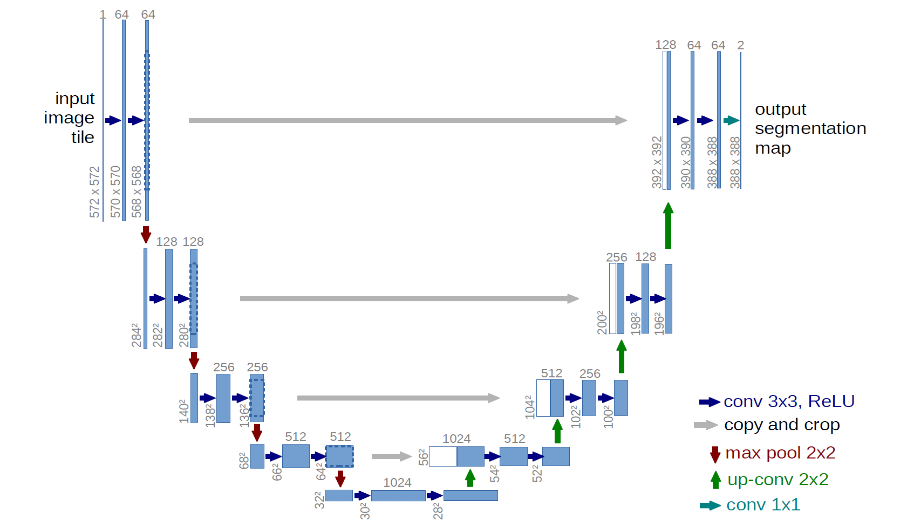

In [93]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def build_unet():
    inputs = Input((dataHandler.IMG_TARGET_ROWS, dataHandler.IMG_TARGET_COLS, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = build_unet()

<h3>2.2 Data augmentation<h3>

In [94]:
from skimage.transform import resize
import cv2

run_id = str(datetime.now())
tb = TensorBoard(log_dir='./logs/{}'.format(run_id), histogram_freq=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=1e-6)
# Use ImageGenerator from keras
datagen = ImageDataGenerator(rotation_range= 5, width_shift_range= 10, height_shift_range= 10) 

def filter_mask_presence(imgs, masks, presence=True):
    """
    Extracts samples by mask presence
    """
    has_mask = np.where([np.count_nonzero(mask) > 0 for mask in masks])
    if not presence:
        has_mask = not has_mask
    return imgs[has_mask], masks[has_mask]

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], dataHandler.IMG_TARGET_ROWS, dataHandler.IMG_TARGET_COLS), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (dataHandler.IMG_TARGET_COLS, dataHandler.IMG_TARGET_ROWS), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

def ppreprocess(imgs, to_rows=None, to_cols=None):
    """
    An alternative preprocess function
    """
    if to_rows is None or to_cols is None:
        to_rows = dataHandler.IMG_ORIG_ROWS
        to_cols = dataHandler.IMG_ORIG_COLS
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], dataHandler.IMG_ORIG_ROWS, dataHandler.IMG_ORIG_COLS), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (dataHandler.IMG_ORIG_COLS, dataHandler.IMG_ORIG_ROWS), interpolation=cv2.INTER_CUBIC)
    return imgs_p


def transform(img, mask, augment=True):
    """
    Transforms an (img, mask) pair with same augmentation params
    """
    if augment:
        img, mask = datagen.flow(np.array([img, mask]))
    img = preprocess(img)
    mask = preprocess(mask).astype('float32') / 255.
    return np.array([img]), np.array([mask])

## "To be implemented in training part"




<h3>2.3 Train model <h3>

In [95]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = dataHandler.load_train_data("cleaned")
    print(imgs_train.shape)
    print(imgs_mask_train.shape)


    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = build_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    print(imgs_train.shape)
    print(imgs_mask_train.shape)
    model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=1, shuffle=True,
              validation_split=0.2, callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)

    imgs_test, imgs_id_test = dataHandler.load_test_data()
    print(imgs_test[0].shape)
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    #     imgs_eval, imgs_mask_eval = dataHandler.load_eval_data("cleaned")
    #     print(imgs_eval.shape)
    #     print(imgs_mask_eval.shape)
    #     imgs_eval = preprocess(imgs_eval)
    #     imgs_mask_eval = preprocess(imgs_mask_eval)
    #     imgs_eval = imgs_eval.astype('float32')

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, imgs_id_test):
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
(369, 420, 580)
(369, 420, 580)


C:\Users\Hunter\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
(369, 96, 96, 1)
(369, 96, 96, 1)
Train on 295 samples, validate on 74 samples
Epoch 1/20
295/295 [==============================] - 58s - loss: -0.0147 - dice_coef: 0.0147 - val_loss: -0.0115 - val_dice_coef: 0.0115
Epoch 2/20
295/295 [==============================] - 57s - loss: -0.0148 - dice_coef: 0.0148 - val_loss: -0.0116 - val_dice_coef: 0.0116
Epoch 3/20
295/295 [==============================] - 55s - loss: -0.0148 - dice_coef: 0.0148 - val_loss: -0.0116 - val_dice_coef: 0.0116
Epoch 4/20
295/295 [==============================] - 55s - loss: -0.0149 - dice_coef: 0.0149 - val_loss: -0.0116 - val_dice_coef: 0.0116
Epoch 5/20
295/295 [==============================] - 55s - loss: -0.0149 - dice_coef: 0.0149 - val_loss: -0.0117 - val_dice_coef: 0.0117
Epoch 6/20
295/295 [==============================] - 55s 

<h1>3 Submit<h1>

In [96]:
from __future__ import print_function

import numpy as np
from skimage.transform import resize


def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (dataHandler.IMG_ORIG_COLS, dataHandler.IMG_ORIG_ROWS), preserve_range=True)
    return img


def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])


def submission():
    imgs_test, imgs_id_test = dataHandler.load_test_data()
    imgs_test = np.load('imgs_mask_test.npy')

    argsort = np.argsort(imgs_id_test)
    imgs_id_test = imgs_id_test[argsort]
    imgs_test = imgs_test[argsort]

    total = imgs_test.shape[0]
    ids = []
    rles = []
    for i in range(total):
        img = imgs_test[i, 0]
        img = prep(img)
        rle = run_length_enc(img)

        rles.append(rle)
        ids.append(imgs_id_test[i])

        if i % 100 == 0:
            print('{}/{}'.format(i, total))

    first_row = 'img,pixels'
    file_name = 'submission.csv'

    with open(file_name, 'w+') as f:
        f.write(first_row + '\n')
        for i in range(total):
            s = str(ids[i]) + ',' + rles[i]
            f.write(s + '\n')

submission()

C:\Users\Hunter\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0/500
100/500
200/500
300/500
400/500
